In [1]:
import torch
import utils
import get_face
import random
from PIL import Image
from model_irse import IR_50

def init_model(model, param, device):
    m = model([112,112])
    m.eval()
    m.to(device)
    m.load_state_dict(torch.load(param))
    return m


def get_img_pool(person_list, device):
    person_pool = []
    for el in person_list:
        person_pool.append(utils.to_torch_tensor(Image.open(el)).unsqueeze_(0).to(device))
    return person_pool


def get_mean_v(img_pool, model, device):
    v_list = []
    if img_pool != None and len(img_pool) > 0:
        for img in img_pool:
            v_list.append(utils.l2_norm(model(img))) 
        v_mean = torch.cat(v_list, 0).sum(0).unsqueeze_(0) / len(img_pool)
        v_mean.detach_()
        return v_mean
    else:
        return None

    
def get_init_noise(device):
    noise = torch.Tensor(1, 3, 112, 112)
    noise = torch.nn.init.xavier_normal(noise, gain=5)
    return noise.to(device)

    
origin_name = 'chengqiang'
target_name = 'guoth'
device = torch.device('cpu')

crop_paths, gen_paths, imgs_dis, people = get_face.get_crop_face_file(get_face.crop_root, get_face.gen_root, gen=False)
start_index = [0]
s = 0
for i in range(len(imgs_dis) - 1 ):
    s += imgs_dis[i]
    start_index.append(s)

people_map = utils.list2map(people)
origin_person = people_map[origin_name]
target_person = people_map[target_name]

s1 = start_index[origin_person]
s2 = s1 + imgs_dis[origin_person]
same_person_list = crop_paths[s1:s2]
s1 = start_index[target_person]
s2 = s1 + imgs_dis[target_person]
target_face_list = crop_paths[s1:s2]
s = len(same_person_list)
index = random.randint(0, s - 1)
img_origin = same_person_list.pop(index)
print(img_origin)
img_origin = utils.to_torch_tensor(Image.open(img_origin)) 
img_origin = img_origin.unsqueeze_(0).to(device)
same_person_pool = get_img_pool(same_person_list, device)
target_face_pool = get_img_pool(target_face_list, device)

['', '/root/anaconda3/lib/python36.zip', '/root/anaconda3/lib/python3.6', '/root/anaconda3/lib/python3.6/lib-dynload', '/root/anaconda3/lib/python3.6/site-packages', '/root/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/root/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/root/.ipython', '/root/workspace/face.evoLVe.PyTorch/align', '/root/workspace/face.evoLVe.PyTorch/backbone']
/root/workspace/face.evoLVe.PyTorch/data/crop_face/chengqiang/39.png


In [2]:
model = init_model(IR_50, 'models/backbone_ir50_ms1m_epoch120.pth', device)

print('caculate v1 mean-------')
v1_mean = get_mean_v(same_person_pool, model, device)
print('caculate v2 mean--------')
v2_mean = get_mean_v(target_face_pool, model, device)

caculate v1 mean-------
caculate v2 mean--------


In [3]:
noise = get_init_noise(device)

In [4]:
target_attack = True
lr = 2

for i in range(200):
    noise.requires_grad = True
    v1 = utils.l2_norm(model(img_origin + noise))

    if target_attack:
        loss1 = 1 - (v1 * v2_mean).sum()
    else:
        loss1 = (v1 * v1_mean).sum()

    loss2 = (noise ** 2).sum()

    # C&W loss
    if loss1.item() < 0.1:  
        loss = 0.1 + 0.025 * loss2
    else:
        loss = loss1 + 0.025 * loss2

    loss.backward()
    print(loss1.item(), loss2.sqrt().item() * 128 / 112, noise.grad.abs().sum())


 #   if loss1 < 0.5:
#        lr = 0.5 * lr
    if loss1 < 0.2:
        lr = 0.5 * lr    
    noise = noise.detach() - lr * noise.grad.detach()
    # noise = (noise + img_origin).clamp_(-1, 1) - img_origin
    # noise = noise.clamp_(-0.2, 0.2)

0.8469853401184082 6.984341212681362 tensor(69.7907)
0.6682920455932617 6.356812068394253 tensor(60.7742)
0.5327918529510498 5.8143512180873325 tensor(48.8263)
0.4769361615180969 5.33751950945173 tensor(42.4448)
0.4391644597053528 4.890846797398159 tensor(37.8106)
0.4067380428314209 4.530388695853097 tensor(34.9365)
0.38281309604644775 4.204600470406668 tensor(31.8724)
0.36965078115463257 3.9234166826520647 tensor(30.4340)
0.353520929813385 3.6921116965157643 tensor(27.7634)
0.34874439239501953 3.475086212158203 tensor(30.8481)
0.3573451638221741 3.3454693385532925 tensor(42.1040)
0.38893765211105347 3.1560600825718472 tensor(39.6270)
0.33316922187805176 3.1249002729143416 tensor(29.4232)
0.32277143001556396 2.9898079463413785 tensor(30.1063)
0.324579119682312 2.9109366280691966 tensor(35.3322)
0.3348544239997864 2.8117517743791853 tensor(35.6404)
0.3192461133003235 2.8113632202148438 tensor(34.1567)
0.3192934989929199 2.736840384347098 tensor(26.9688)
0.2921186089515686 2.726339340209

0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9.0586)
0.17700201272964478 2.898235866001674 tensor(9

In [5]:
adv_sample = utils.get_adv_sample(noise.data, img_origin)
adv_sample_t = utils.to_torch_tensor(adv_sample).unsqueeze_(0).to(device)
v1_adv = utils.l2_norm(model(adv_sample_t))
v1 = utils.l2_norm(model(img_origin))


In [6]:
print((v1 * v1_mean).sum())
print((v1_adv * v1_mean).sum())
print((v1 * v2_mean).sum())
print((v1_adv * v2_mean).sum())

tensor(0.9432, grad_fn=<SumBackward0>)
tensor(0.2690, grad_fn=<SumBackward0>)
tensor(0.1402, grad_fn=<SumBackward0>)
tensor(0.8221, grad_fn=<SumBackward0>)


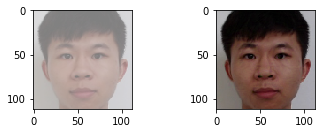

In [12]:
import matplotlib.pyplot as plt

img_origin_x = utils.to_pil_image(img_origin[0])
def plot_images(imgs):
    for i,img in enumerate(imgs):
        plt.subplot(2,2,i+1)
        plt.imshow(imgs[i])
        
        
plot_images([img_origin_x, adv_sample])

In [10]:
import numpy as np
img1 = np.array(img_origin_x, dtype=float)
img2 = np.array(adv_sample, dtype=float)
np.abs((img1-img2)).max()

22.0

In [32]:
img_origin[0,0,0,0] = -1

In [33]:
img_origin

tensor([[[[-1.0000,  0.9912,  0.9911,  ...,  0.9908,  0.9907,  0.9907],
          [ 0.9911,  0.9912,  0.9909,  ...,  0.9907,  0.9906,  0.9906],
          [ 0.9911,  0.9913,  0.9911,  ...,  0.9907,  0.9906,  0.9906],
          ...,
          [ 0.9855,  0.9853,  0.9852,  ...,  0.9892,  0.9893,  0.9893],
          [ 0.9857,  0.9854,  0.9852,  ...,  0.9895,  0.9893,  0.9893],
          [ 0.9858,  0.9854,  0.9852,  ...,  0.9893,  0.9893,  0.9893]],

         [[ 0.9912,  0.9912,  0.9911,  ...,  0.9907,  0.9906,  0.9906],
          [ 0.9911,  0.9912,  0.9909,  ...,  0.9906,  0.9904,  0.9904],
          [ 0.9911,  0.9913,  0.9911,  ...,  0.9906,  0.9904,  0.9904],
          ...,
          [ 0.9849,  0.9847,  0.9846,  ...,  0.9891,  0.9892,  0.9892],
          [ 0.9850,  0.9848,  0.9846,  ...,  0.9893,  0.9892,  0.9892],
          [ 0.9852,  0.9848,  0.9846,  ...,  0.9892,  0.9892,  0.9892]],

         [[ 0.9914,  0.9914,  0.9913,  ...,  0.9913,  0.9912,  0.9912],
          [ 0.9913,  0.9914,  

In [45]:
import torchvision
transform = torchvision.transforms.Normalize([-1, -1, -1],[2, 2, 2], False)
                      
img_origin1 = transform(img_origin[0])
img_origin1

TypeError: __init__() takes 3 positional arguments but 4 were given

In [46]:
torchvision.__version__

'0.2.1'